# Recommendation System with MovieLens Dataset
Related datasets can be found here http://grouplens.org/datasets/movielens/

## Dataset Exploration

In [72]:
import os
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import numpy as np
import random
random.seed(42)

In [3]:
link = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"

# download to ./data if not already downloaded
target = "data/ml-100k"
if not os.path.exists(target):
    os.system("wget " + link + " -P data")
    os.system(f"unzip {target}.zip -d data")
    os.system(f"rm {target}.zip")

In [6]:
items_path = "data/ml-100k/u.item"
ratings_path = "data/ml-100k/u.data"
users_path = "data/ml-100k/u.user"
genres_path = "data/ml-100k/u.genre"
occupation_path = "data/ml-100k/u.occupation"

genre_dict = {}
with open(genres_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        if line == "\n":
            break
        genre, id = line.strip().split("|")
        genre_dict[int(id)] = genre
        
print(genre_dict)

header = ["user_id", "item_id", "rating", "timestamp"]
items_df = pd.read_csv(items_path, sep="|", encoding="ISO-8859-1", header=None)

# rename columns
items_df.columns = ["item_id", "title", "release_date", "video_release_date", "imdb_url"] + [genre_dict[i] for i in range(19)]

items_df.head(5)

{0: 'unknown', 1: 'Action', 2: 'Adventure', 3: 'Animation', 4: "Children's", 5: 'Comedy', 6: 'Crime', 7: 'Documentary', 8: 'Drama', 9: 'Fantasy', 10: 'Film-Noir', 11: 'Horror', 12: 'Musical', 13: 'Mystery', 14: 'Romance', 15: 'Sci-Fi', 16: 'Thriller', 17: 'War', 18: 'Western'}


,item_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


0       1995.0
1       1995.0
2       1995.0
3       1995.0
4       1995.0
         ...  
1677    1998.0
1678    1998.0
1679    1998.0
1680    1994.0
1681    1996.0
Name: 2, Length: 1682, dtype: float64


Text(0.5, 1.0, 'Release year counts')

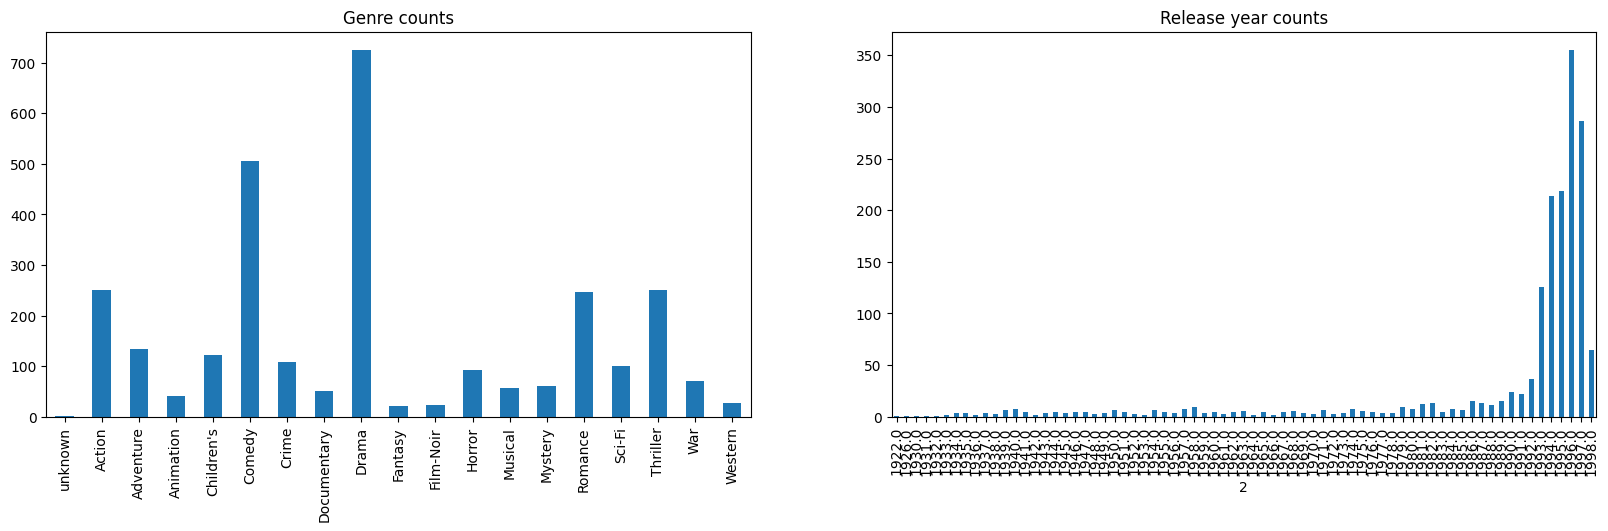

In [37]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))

# Graph genres counts and set genre names
genres = items_df.iloc[:, 5:].sum()
# Default ints are 5 to 24, so we need to add 5 to get the correct genre id
genres.index = [genre_dict[int(i)] for i in genres.index - 5]
genres.plot(kind="bar", ax=axes[0])
axes[0].set_title("Genre counts")

# Graph release year counts, from format 01-Jan-1995 to 1995, must be string, not float
release_years = items_df.iloc[:, 2]
release_years = release_years.apply(lambda x: datetime.strptime(str(x), "%d-%b-%Y").year if pd.notnull(x) else x)
release_years.value_counts().sort_index().plot(kind="bar", ax=axes[1])
axes[1].set_title("Release year counts")



In [48]:
ratings_df = pd.read_csv(ratings_path, sep="\t", header=None)
ratings_df.columns = ["user_id", "item_id", "rating", "timestamp"]

# Merge ratings with items, but only keep the title and genre columns
merged_df = ratings_df.merge(items_df[["item_id", "title"]], on="item_id")

merged_df.head(5)

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [68]:
unique_users = ratings_df["user_id"].nunique()
unique_movies = ratings_df["item_id"].nunique()

print(f"Unique users: {unique_users}")
print(f"Unique movies: {unique_movies}")

Unique users: 943
Unique movies: 1682


In [49]:
# Group by unique user id and movie title, ratings by same user on the same movie will be averaged
merged_df = merged_df.groupby(["user_id", "title"]).mean().reset_index()
merged_df.head(5)

,user_id,title,item_id,rating,timestamp
0,1,101 Dalmatians (1996),225.0,2.0,878542738.0
1,1,12 Angry Men (1957),178.0,5.0,878543541.0
2,1,"20,000 Leagues Under the Sea (1954)",141.0,3.0,878542608.0
3,1,2001: A Space Odyssey (1968),135.0,4.0,875072404.0
4,1,"Abyss, The (1989)",164.0,3.0,876893171.0


In [52]:
# Create a new dataframe with just user_id, title, and rating columns
# Drop the item_id and timestamp columns
refined_df = merged_df.drop(["item_id", "timestamp"], axis=1)
refined_df.head(5)

,user_id,title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


Text(0, 0.5, 'Count')

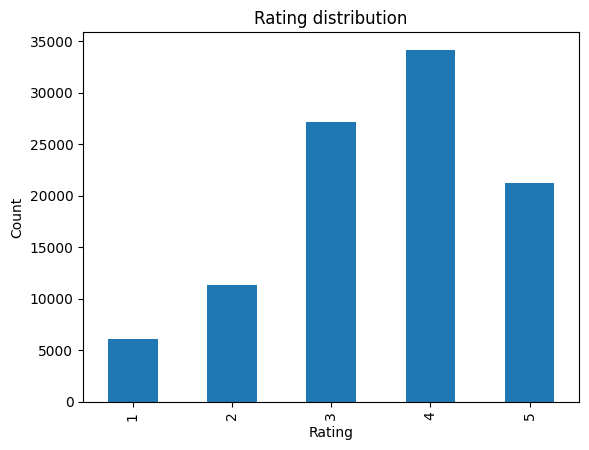

In [12]:
# Distribution of ratings
ratings_df["rating"].value_counts().sort_index().plot(kind="bar")
# Set title and labels
plt.title("Rating distribution")
plt.xlabel("Rating")
plt.ylabel("Count")

## Memory Based Collaborative Filtering

### User-Based CF

- train_df memory size: 35304.67 MB
- train_sparse memory size: 25.51 MB

### Item-Based CF (KNN)

Need to reshape the data in such as way that each row of the dataframe represents a movie and each column represents a users. So we want the data to be [movies, users] array if the movie is the subject where similar movies must be found and [users, movies] where similar users must be found.

1. Pivot dataframe with movies as rows and users as columns.
2. Fill mising values (not all users wath all movies) with 0s since we are going to perform linear algebra operations (calculating distance between vectors)
3. Transform the values of the dataframe into scipy parse matrix for efficient calculations.

Goals
1. Train a KNN model to find closely matching similar users to a given user. Therfore we can recommend the top movies that would interest the given user based on the similar users.
2. Train a KNN model to find closely matching similar moves to a given movie (input). Should recomend top movies that aligh more closely to the given movie.

In [53]:
# 1. Pivot dataframe to have user_id as index, movie title as columns, and ratings as values
user_to_movie_df = refined_df.pivot(index="user_id", columns="title", values="rating")
user_to_movie_df = user_to_movie_df.fillna(0)
user_to_movie_df.head(5)


title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0


In [55]:
# 2. Transform the matrix to a sparse matrix
user_to_movie_sparse = csr_matrix(user_to_movie_df.values)

print("Memory usage of non-sparse matrix: ", user_to_movie_df.memory_usage().sum() / 1024**2, "MB")
print("Memory usage of sparse matrix: ", user_to_movie_sparse.data.nbytes / 1024**2, "MB")
print("Sparsity: ", 1 - user_to_movie_sparse.nnz / (user_to_movie_sparse.shape[0] * user_to_movie_sparse.shape[1]))

user_to_movie_sparse

Memory usage of non-sparse matrix:  11.978874206542969 MB
Memory usage of sparse matrix:  0.7605972290039062 MB


<943x1664 sparse matrix of type '<class 'numpy.float64'>'
	with 99693 stored elements in Compressed Sparse Row format>

In [57]:
# 3. Fitting KNN model to the sparse matrix
knn_model = NearestNeighbors(
    metric="cosine", 
    algorithm="brute", 
    n_neighbors=5, 
    p=2,
    radius=1.0,
    n_jobs=-1
)
knn_model.fit(user_to_movie_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1)

In [77]:
def get_similar_users(knn_model, user, n = 5):
  """
  Function to find top n similar users of the given input user
  
  Args:
  knn_model : KNN model object
  user: int : user id, user to find similar users
  n : int : number of similar users to find
  """
  knn_input = np.asarray([user_to_movie_df.values[user-1]])  
  distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
  
  print("Top",n,"users who are very much similar to the User-",user, "are: ")
  print(" ")
  for i in range(1,len(distances[0])):
    print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
  return indices.flatten()[1:] + 1, distances.flatten()[1:]

In [81]:
from pprint import pprint
# user_id = random.randint(1, unique_users)
user_id = 778
print("Few of movies seen by the User:")
pprint(list(refined_df[refined_df['user_id'] == user_id]['title'])[:10])
similar_user_list, distance_list = get_similar_users(knn_model, user_id,5)

Few of movies seen by the User:
['Amityville Horror, The (1979)',
 'Angels in the Outfield (1994)',
 'Apocalypse Now (1979)',
 'Apollo 13 (1995)',
 'Austin Powers: International Man of Mystery (1997)',
 'Babe (1995)',
 'Back to the Future (1985)',
 'Blues Brothers, The (1980)',
 'Chasing Amy (1997)',
 'Clerks (1994)']
Top 5 users who are very much similar to the User- 778 are: 
 
1 . User: 124 separated by distance of 0.4586649429539592
2 . User: 933 separated by distance of 0.5581959868865324
3 . User: 56 separated by distance of 0.5858413112292744
4 . User: 738 separated by distance of 0.5916272517988691
5 . User: 653 separated by distance of 0.5991479757406326


Now we have to pick the top movies to recommend. One way would be taking the average of the existing ratings given by the similar users by picking the top 10 or 15 movies to recommend to the current user.

An improvement would to define weights to ratings by each similar user based on their distance from the input user. Defining these weights would give us the accurate recommendations by elminating the chance of decision manipulation by users who are relatively further from the input user,

In [96]:
similar_user_list, distance_list

(array([124, 933,  56, 738, 653]),
 array([0.45866494, 0.55819599, 0.58584131, 0.59162725, 0.59914798]))

In [97]:
weighted_list = distance_list / np.sum(distance_list)
weighted_list

array([0.16419139, 0.19982119, 0.20971757, 0.2117888 , 0.21448105])

In [98]:
# Get the movie ratings of the similar users
mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
mov_rtngs_sim_users

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [99]:
movie_list = user_to_movie_df.columns
movie_list

Index([''Til There Was You (1997)', '1-900 (1994)', '101 Dalmatians (1996)',
       '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)',
       '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)',
       '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)',
       ...
       'Yankee Zulu (1994)', 'Year of the Horse (1997)', 'You So Crazy (1994)',
       'Young Frankenstein (1974)', 'Young Guns (1988)',
       'Young Guns II (1990)', 'Young Poisoner's Handbook, The (1995)',
       'Zeus and Roxanne (1997)', 'unknown',
       'Á köldum klaka (Cold Fever) (1994)'],
      dtype='object', name='title', length=1664)

In [100]:
print("Weightage list shape:", len(weighted_list))
print("mov_rtngs_sim_users shape:", mov_rtngs_sim_users.shape)
print("Number of movies:", len(movie_list))

Weightage list shape: 5
mov_rtngs_sim_users shape: (5, 1664)
Number of movies: 1664


In [101]:
# Broadcasting the weighted list to the shape of mov_rtngs_sim_users for element wise multiplication
weighted_list = weighted_list[:, np.newaxis] + np.zeros(len(movie_list))
weighted_list.shape

(5, 1664)

In [103]:
# Updating the ratings of the similar users with the weights
new_rating_matrix = mov_rtngs_sim_users * weighted_list
mean_rating_list = new_rating_matrix.sum(axis=0)
mean_rating_list


array([0.        , 0.        , 1.02879509, ..., 0.        , 0.        ,
       0.        ])

In [105]:
from pprint import pprint
def recommend_movies(n):
  n = min(len(mean_rating_list),n)
  pprint(list(movie_list[np.argsort(mean_rating_list)[::-1][:n]]))

print("Top 10 recommended movies for User-",user_id)
recommend_movies(10)

Top 10 recommended movies for User- 778
['Star Wars (1977)',
 'Terminator, The (1984)',
 "Schindler's List (1993)",
 'Fugitive, The (1993)',
 'Forrest Gump (1994)',
 'Princess Bride, The (1987)',
 'Empire Strikes Back, The (1980)',
 'Pulp Fiction (1994)',
 'Die Hard (1988)',
 'Monty Python and the Holy Grail (1974)']


There are a couple drawbacks of this method
1. Recommends movies which are already seen by the given input users
2. Recommends movies which are not at all seen by any of the similar users